# Data Pre Processing

In [1]:
import cv2
import numpy as np
import tensorflow as tf
import pandas as pd 
import matplotlib.pyplot as plt
import os

from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder , OneHotEncoder

from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

dataset_path = os.listdir(r'dataset/Original')

print (dataset_path)
print("Types of classes labels found: ", len(dataset_path))

['Benign', 'Early', 'Pre', 'Pro']
Types of classes labels found:  4


In [2]:
class_labels = []

for item in dataset_path:
 all_classes = os.listdir(r'dataset/Original' + '/' +item)
 
 for room in all_classes:
    class_labels.append((item, str('dataset_path' + '/' +item) + '/' + room))

In [3]:
df = pd.DataFrame(data=class_labels, columns=['Labels', 'image'])
print(df.head())
print(df.tail())

   Labels                                   image
0  Benign  dataset_path/Benign/WBC-Benign-001.jpg
1  Benign  dataset_path/Benign/WBC-Benign-002.jpg
2  Benign  dataset_path/Benign/WBC-Benign-003.jpg
3  Benign  dataset_path/Benign/WBC-Benign-004.jpg
4  Benign  dataset_path/Benign/WBC-Benign-005.jpg
     Labels                                       image
3251    Pro  dataset_path/Pro/WBC-Malignant-Pro-800.jpg
3252    Pro  dataset_path/Pro/WBC-Malignant-Pro-801.jpg
3253    Pro  dataset_path/Pro/WBC-Malignant-Pro-802.jpg
3254    Pro  dataset_path/Pro/WBC-Malignant-Pro-803.jpg
3255    Pro  dataset_path/Pro/WBC-Malignant-Pro-804.jpg


In [4]:
path = 'dataset/Original/'
dataset_path = os.listdir('dataset/Original')

im_size = 224

images = []
labels = []

for i in dataset_path:
    data_path = path + str(i)  
    filenames = [i for i in os.listdir(data_path) ]
   
    for f in filenames:
        img = cv2.imread(data_path + '/' + f)
        img = cv2.resize(img, (im_size, im_size))
        images.append(img)
        labels.append(i)

In [5]:
images = np.array(images)
images = images.astype('float32') / 255.0
images.shape

(3256, 224, 224, 3)

In [6]:
y=df['Labels'].values
print(y)

y_labelencoder = LabelEncoder ()
y = y_labelencoder.fit_transform (y)
print (y)

['Benign' 'Benign' 'Benign' ... 'Pro' 'Pro' 'Pro']
[0 0 0 ... 3 3 3]


In [31]:
# Reshape and one-hot encode the labels
y = y.reshape(-1, 1)
ct = ColumnTransformer([('my_ohe', OneHotEncoder(), [0])], remainder='passthrough')
Y = ct.fit_transform(y).toarray()
print(Y[:5])
print(Y[35:])

# Shuffle the images and labels
images, Y = shuffle(images, Y, random_state=1)

# Split the data into training and temporary sets
train_x, temp_x, train_y, temp_y = train_test_split(images, Y, test_size=0.30, random_state=415)

# Split the temporary set into validation and test sets
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y, test_size=0.50, random_state=415)

# Inspect the shape of the training, validation, and testing sets
print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)


(2767, 224, 224, 3)
(2767, 4)


# EfficientNet Implementation

In [32]:
def build_model(num_classes):
    inputs = layers.Input(shape=(224, 224, 3))
    x = inputs
    model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(4, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNetB0")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [33]:
model = build_model(num_classes=4)

In [34]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [35]:
%timeit
with tf.device('/GPU:0'):
    hist = model.fit(train_x, train_y, epochs=100, verbose=2)
    hist

Epoch 1/100
87/87 - 12s - loss: 1.9722 - accuracy: 0.2635 - 12s/epoch - 133ms/step
Epoch 2/100
87/87 - 5s - loss: 1.7767 - accuracy: 0.2711 - 5s/epoch - 60ms/step
Epoch 3/100
87/87 - 5s - loss: 1.6823 - accuracy: 0.2754 - 5s/epoch - 62ms/step
Epoch 4/100
87/87 - 5s - loss: 1.6152 - accuracy: 0.2721 - 5s/epoch - 60ms/step
Epoch 5/100
87/87 - 6s - loss: 1.5797 - accuracy: 0.2786 - 6s/epoch - 65ms/step
Epoch 6/100
87/87 - 6s - loss: 1.5468 - accuracy: 0.2801 - 6s/epoch - 72ms/step
Epoch 7/100
87/87 - 6s - loss: 1.5244 - accuracy: 0.2790 - 6s/epoch - 72ms/step
Epoch 8/100
87/87 - 6s - loss: 1.4842 - accuracy: 0.2754 - 6s/epoch - 70ms/step
Epoch 9/100
87/87 - 6s - loss: 1.4393 - accuracy: 0.2884 - 6s/epoch - 71ms/step
Epoch 10/100
87/87 - 6s - loss: 1.4259 - accuracy: 0.2891 - 6s/epoch - 71ms/step
Epoch 11/100
87/87 - 5s - loss: 1.4288 - accuracy: 0.2949 - 5s/epoch - 63ms/step
Epoch 12/100
87/87 - 5s - loss: 1.4200 - accuracy: 0.2768 - 5s/epoch - 59ms/step
Epoch 13/100
87/87 - 5s - loss: 1.

In [36]:
def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

model.summary()

Model: "EfficientNetB0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 224, 224, 3)  0           ['input_2[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 224, 224, 3)  7          ['rescaling_2[0][0]']            
 )                                                                                                
                                                                                     

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = model.predict(train_x)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_y, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Performance Metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

Input image shape: (1, 224, 224, 3)
1/1 [==============================] - 0s 25ms/step
predicted class:  [[9.9915230e-01 8.4764324e-04 3.6159924e-27 7.1512016e-22]]


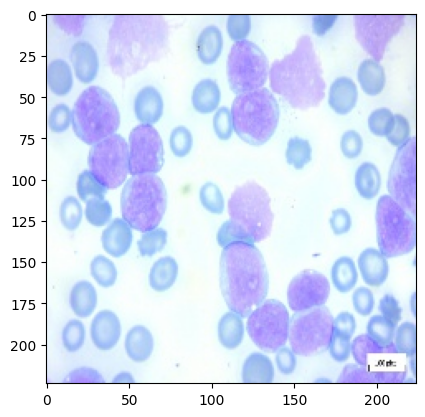

In [27]:
img_path = r'D:\Leukemia Classification and Segmentation\dataset\Original\Pre\WBC-Malignant-Pre-026.jpg'

img = cv2.imread(img_path)
img = cv2.resize(img, (224, 224))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)

print('Input image shape:', x.shape)

my_image = imread(img_path)
imshow(my_image)

preds=model.predict(x)
print("predicted class: ", preds )    # probabilities for being in each of the 3 classes